In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf
import os
import sys

from pathlib import Path
current_dir = Path(os.getcwd())
top_dir = current_dir.parent
sys.path.append(str(top_dir))


from svae.SVAE import SVAE
from svae.train import train
from svae.generate import generate_sequences
from utils.data_processing import prep_data, make_tf_batches, seq_to_onehot
from utils.plots import plot_latent_space
pd.set_option('display.expand_frame_repr', False)

2023-03-08 19:47:27.621644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.__version__

'2.11.0'

In [4]:
os.getcwd()

'/Users/yg/code/github/gensaic_take_home_assigment/notebooks'

## Data


In [5]:
df = pd.read_parquet("../data/df_nes_ohe_1000000.parquet")
df.head(2)

,index,sequence,input_count,rep1_count,rep2_count,log2_fold_change,CV,NES,VNES,OHE
0,40018119,CQVLNKDQC,4,2,5,-0.192645,2.333333,-0.221244,-0.094819,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,38529993,CTGGGFNRC,7,1,6,-1.000000,1.400000,-1.148456,-0.820325,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
df.shape

(1000000, 10)

In [7]:
df.describe()

,index,input_count,rep1_count,rep2_count,log2_fold_change,CV,NES,VNES
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2.260039e+07,3.803750,5.140480,5.251291,0.497538,4.162813,0.571401,0.203724
std,1.305889e+07,5.002988,7.722459,7.952456,0.870886,5.490293,1.000173,0.448041
min,1.190000e+02,1.000000,1.000000,1.000000,-5.169925,1.051282,-5.937429,-2.614679
25%,1.128720e+07,1.000000,1.000000,1.000000,0.222392,2.333333,0.255408,0.036487
50%,2.259376e+07,1.000000,2.000000,2.000000,0.584963,3.000000,0.671803,0.223934
75%,3.392169e+07,5.000000,6.000000,6.000000,0.784271,3.000000,0.900701,0.223934
max,4.524463e+07,120.000000,658.000000,701.000000,5.918863,335.000000,6.797552,4.081800


In [8]:
df = df.sample(500000)

In [9]:
#df.shape

### Make Tensorflow-compatible data batches

The training split will be split futher into training and validation batches with `make_tf_batches()`.

In [10]:
(data_list, train_df, test_df, prepped_df) = prep_data(df.copy(), target_assay_col="VNES", AA_colname="sequence")
train_df

(500000, 10)


,AA_sequence,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x171,x172,x173,x174,x175,x176,x177,x178,x179,Y--VNES
0,CHRSFWWFC,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.223934
1,CVAFAVGMC,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.223934
2,CLYSDIMWC,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.430671
3,CFLLDGQVC,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.317768
4,CEYLGQYSC,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.447869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449995,CGSVYIQCC,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.223934
449996,CRFDDKAGC,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.369481
449997,CDSQRCVRC,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.880396
449998,CQQSRGGQC,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.223934


In [11]:
# Pickle dataframes
dfs_dict = {'data_list': data_list, 'train_df': train_df, 'test_df': test_df, 'prepped_df': prepped_df}
Path('saved_vals/').mkdir(parents=True, exist_ok=True)
with open('saved_vals/dfs_dict.pickle', 'wb') as f:
    pickle.dump(dfs_dict, f)

In [12]:
# Load dataframes 
# with open('saved_vals/dfs_dict.pickle', 'rb') as f:
#     dfs_dict = pickle.load(f)

# data_list = dfs_dict['data_list']
# train_df = dfs_dict['train_df']
# test_df = dfs_dict['test_df']
# prepped_df = dfs_dict['prepped_df']

Now we split `train_df` into TensorFlow-compatible training and validation batches using
`make_tf_batches()`. `unbatched_data` is a tuple of Numpy arrays corresponding to the X, Y
and CV (if using) values across both the training and validation batches.


In [13]:
X, Y = data_list
train_batches, val_batches, unbatched_data = make_tf_batches(X, Y, CV=None)

In [14]:
# Save batches to disk
tf.data.experimental.save(train_batches, '../saved_vals/train_batches')
tf.data.experimental.save(val_batches, '../saved_vals/val_batches')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [15]:
# Load Tensorflow batches
train_batches = tf.data.experimental.load('../saved_vals/train_batches')
val_batches = tf.data.experimental.load('../saved_vals/val_batches')

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


## SVAE training

Default parameterization (used in paper):

- `input_dim = 140`
- `latent_dim = 2`
- `enc_hidden_dims = [100,40]`
- `dec_hidden_dims = [40,100]`
- `reg_hidden_dims = [100,10]`


In [16]:
# SVAE parameters (same as default)
input_dim = 140
latent_dim = 2
enc_hidden_dims = [100,40]
dec_hidden_dims = [40,100]
reg_hidden_dims = [100,10]

# training parameters 
loss_weights = [1.0,0.5,0.1] # [reconstruction, KL, regression]

initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

In [17]:
# Initialize SVAE model (with default parameterizations)
model = SVAE(input_dim=180, latent_dim=2, enc_hidden_dims=[100,40], dec_hidden_dims=[40,100], reg_hidden_dims=[100,10], name='svae')
model.summary()

Model: "svae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 180)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          22304       ['encoder_input[0][0]',          
                                 (None, 2),                       'encoder_input[0][0]']          
                                 (None, 2)]                                                       
                                                                                                  
 tf.concat_1 (TFOpLambda)       (None, 182)          0           ['encoder[1][0]',                
                                                                  'encoder_input[0][0]']       

The `train()` function returns the trained `model` and `preds_df`, a DataFrame of
regressor predictions on the X values in `unbatched_data`, along with their latent space
projections and their true Y values.

`train()` saves the trained model, as well as a log of the training and validation loss
values per epoch and `preds_df`, to disk. These saves will be made to an optional
parameter `model_outdir` - if not specified, `train()` will make a new,
informatively-named directory to write to (path is returned).

In [21]:
# Train model
model, preds_df, model_outdir = train(model, train_batches, val_batches, train_df,
                        optimizer=optimizer,
                        loss_weights=loss_weights ,
                        max_epochs = 1,
                        )

Logging following metrics: ['train_model_loss', 'train_reconstruction_loss', 'train_kl_loss', 'train_regression_loss', 'val_model_loss', 'val_reconstruction_loss', 'val_kl_loss', 'val_regression_loss']


----- Beginning training. -----

epoch 1
400000/400000 [==============================] - 5741s 14ms/step - train_model_loss: 20.4288 - train_reconstruction_loss: 20.4096 - train_kl_loss: 6.4439e-05 - train_regression_loss: 0.1918 - val_model_loss: 20.4298 - val_reconstruction_loss: 20.4103 - val_kl_loss: 5.6480e-05 - val_regression_loss: 0.1947
Hit maximum epochs.
Finished training model. Final overall losses:
train: 20.429    val:20.430
14063/14063 [==============================] - 12s 818us/step

MSE of predictions vs true labels: 0.19662126898765564
INFO:tensorflow:Assets written to: /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/model/assets
Model saved to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/20233

In [25]:
1

1

In [26]:
preds_df

,AA_sequence,y_pred,z0,z1,y_true,y_true_scaled,cluster_label,cluster_assay_mean,subcluster_label,subcluster_assay_mean
0,CHRSFWWFC,0.222087,0.003582,-0.007770,0.223934,-0.007252,4,0.203822,NaN,NaN
1,CVAFAVGMC,0.220666,-0.008371,0.001746,0.223934,-0.007252,4,0.203822,NaN,NaN
2,CLYSDIMWC,0.245741,0.002528,0.007400,0.430671,-0.005401,0,0.198554,NaN,NaN
3,CFLLDGQVC,0.189944,0.010960,-0.006433,-0.317768,-0.012103,2,0.203158,NaN,NaN
4,CEYLGQYSC,0.070993,-0.004512,0.008736,-0.447869,-0.013267,0,0.198554,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
449995,CGSVYIQCC,0.206561,-0.002557,0.001768,0.223934,-0.007252,4,0.203822,NaN,NaN
449996,CRFDDKAGC,0.220200,0.010740,-0.015778,0.369481,-0.005949,3,0.211172,5.0,NaN
449997,CDSQRCVRC,0.261643,-0.014906,0.005557,0.880396,-0.001374,1,0.201113,NaN,NaN
449998,CQQSRGGQC,0.114543,-0.006801,0.001766,0.223934,-0.007252,4,0.203822,NaN,NaN


### Plot latent space

Plot saved to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/plots/train_latent_space.png


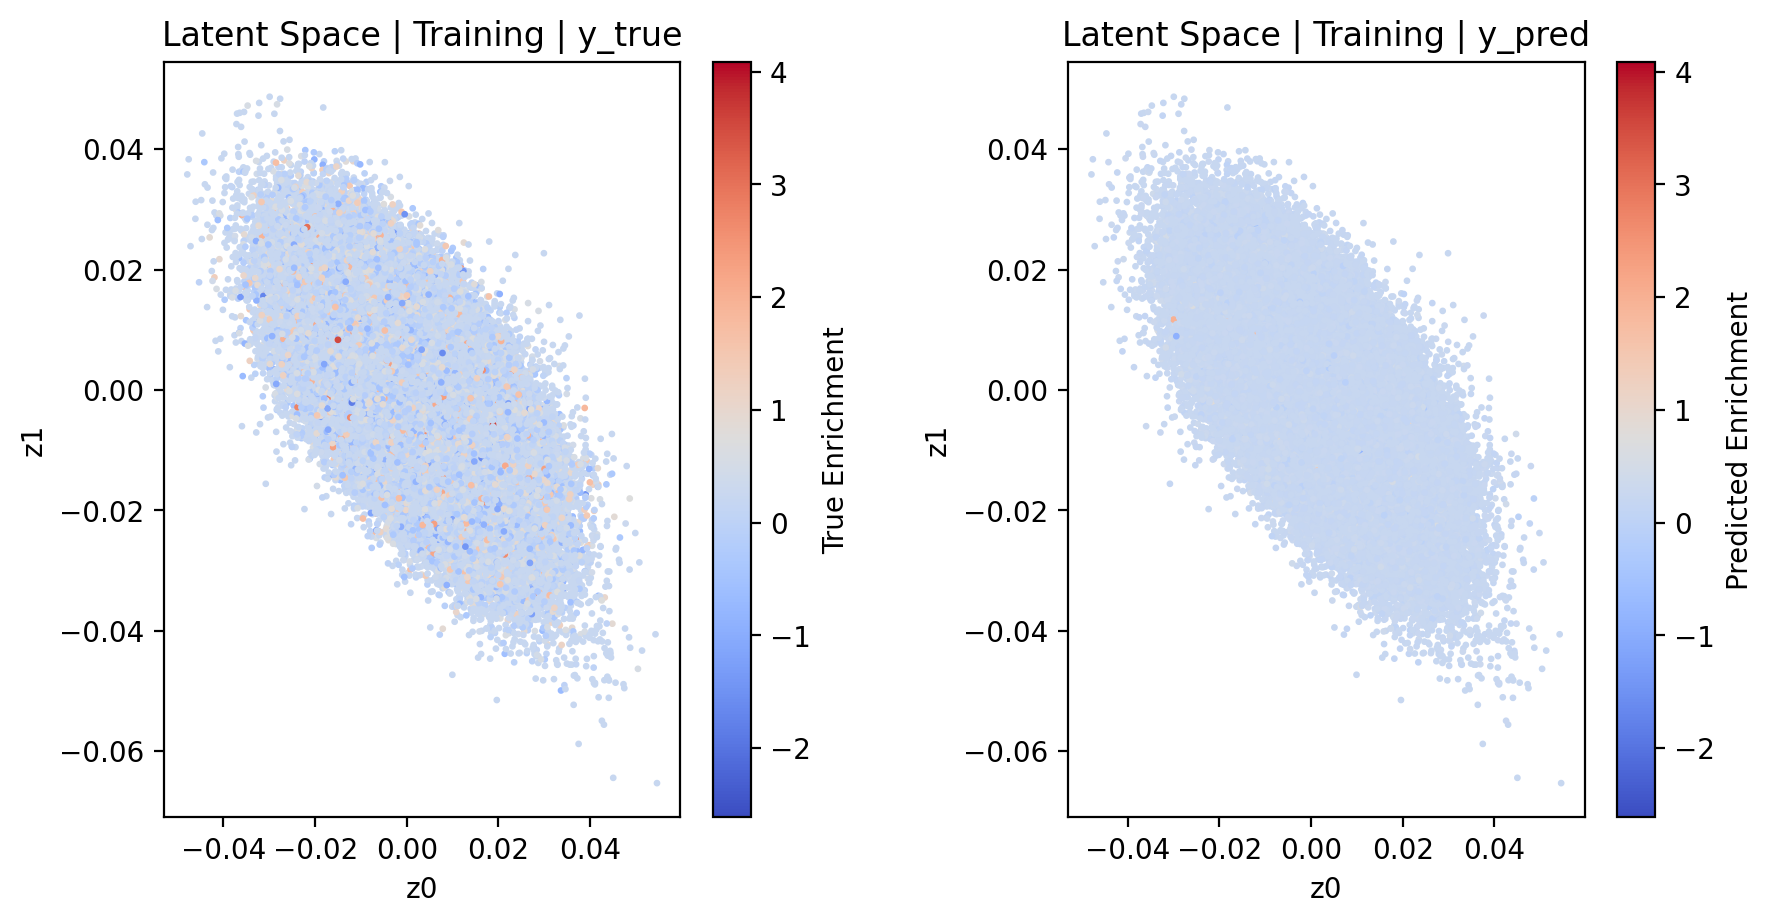

In [27]:
plots_outdir = model_outdir / 'plots'
fig, ax = plot_latent_space(preds_df, plots_outdir=plots_outdir, assay=None)

Plot saved to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/plots/train_latent_space.png


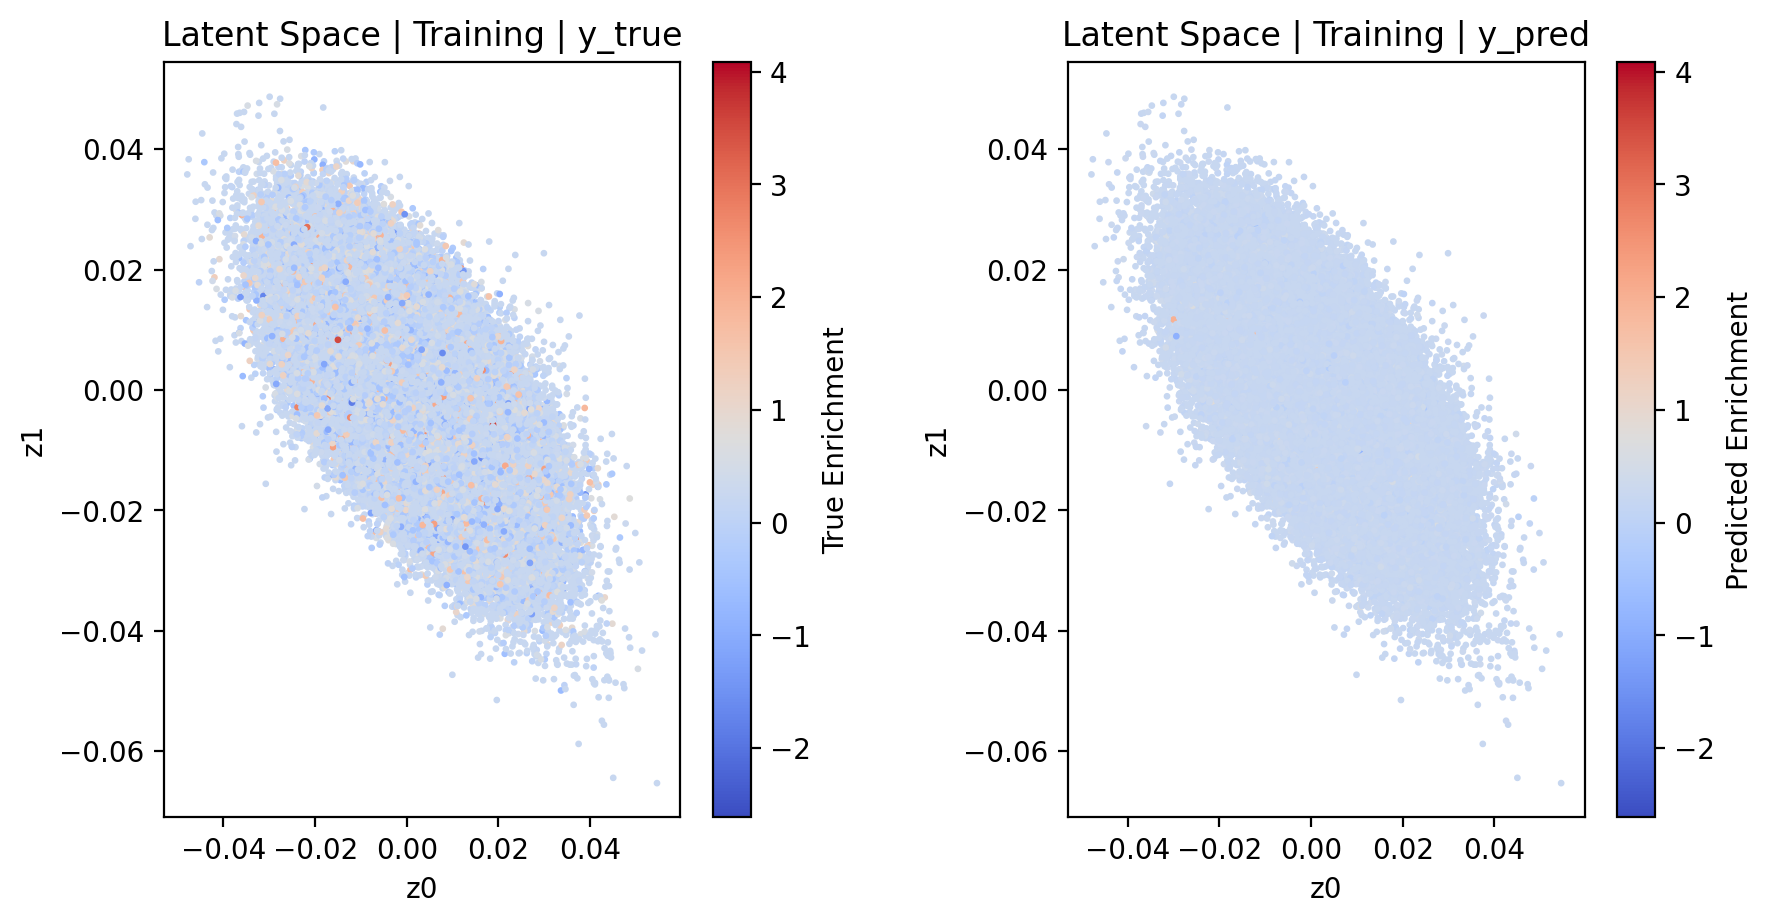

In [29]:
plots_outdir = model_outdir / 'plots'
fig, ax = plot_latent_space(preds_df, plots_outdir=plots_outdir, assay=None)

## Generate novel sequences

Fitting kmeans...
Done fitting kmeans.
Saved clustering model to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/kmeans_models/kmeans.
Plot saved to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/plots/latent_space_clusters.png


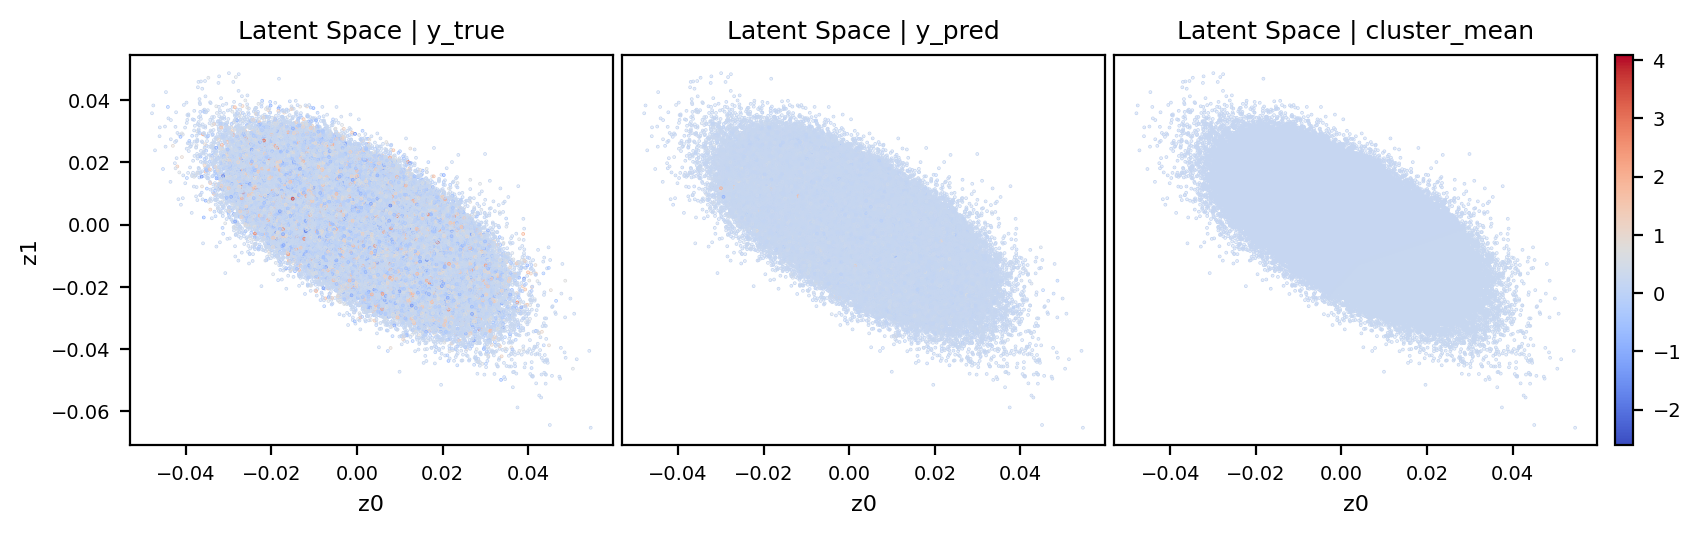


Cluster 1:  mean = 0.21097611094944865, ranking = 0
Logo plot saved to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/plots/cluster_logos/cluster0_mean0.21.png
Fitting kmeans...
Done fitting kmeans.
Saved clustering model to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/kmeans_models/kmeans_sub.
Plot saved to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/plots/subclusters/cluster0_mean0.21_subclusters.png


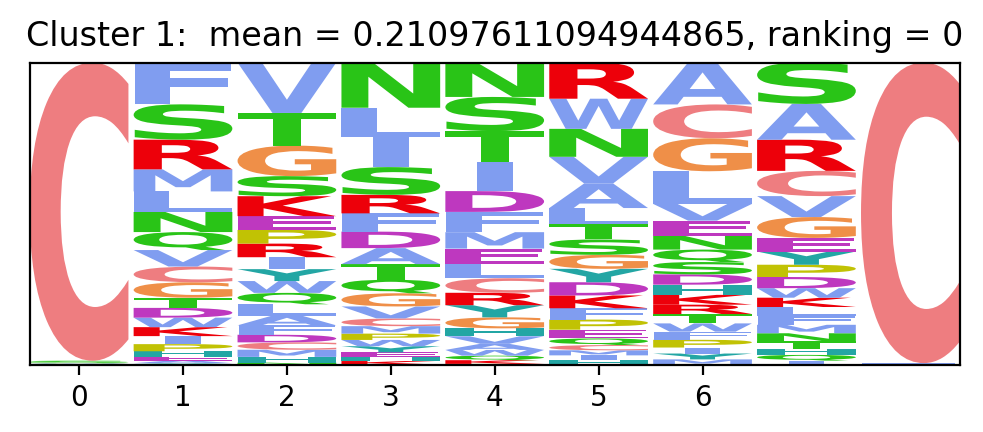

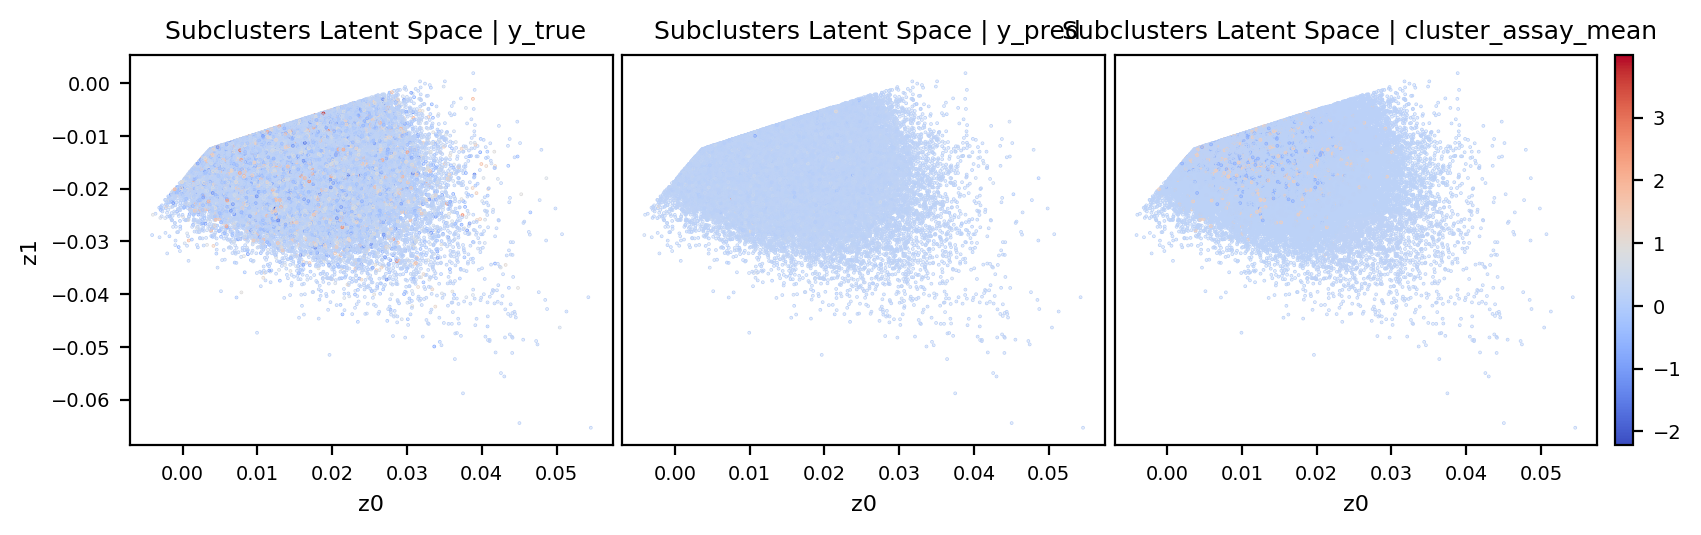


Subcluster 9: mean = 1.4027981549051356, ranking = 0
Logo plot saved to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/plots/subcluster_logos/subcluster0_mean1.40.png
Generating sequences for cluster 1, subcluster 9.
4096 sequences generated.
4096 unique novel sequences generated so far.

Subcluster 4: mean = 0.21077363648897587, ranking = 1
Logo plot saved to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/plots/subcluster_logos/subcluster1_mean0.21.png
Generating sequences for cluster 1, subcluster 4.
16384 sequences generated.
18432 unique novel sequences generated so far.

Subcluster 3: mean = 0.20931825261543116, ranking = 2
Logo plot saved to /Users/yg/code/github/gensaic_take_home_assigment/trained_models/202339_VNES_2D_1epochs_20.43T_20.43V/plots/subcluster_logos/subcluster2_mean0.21.png
Generating sequences for cluster 1, subcluster 3.
16384 sequences generated.
31792 

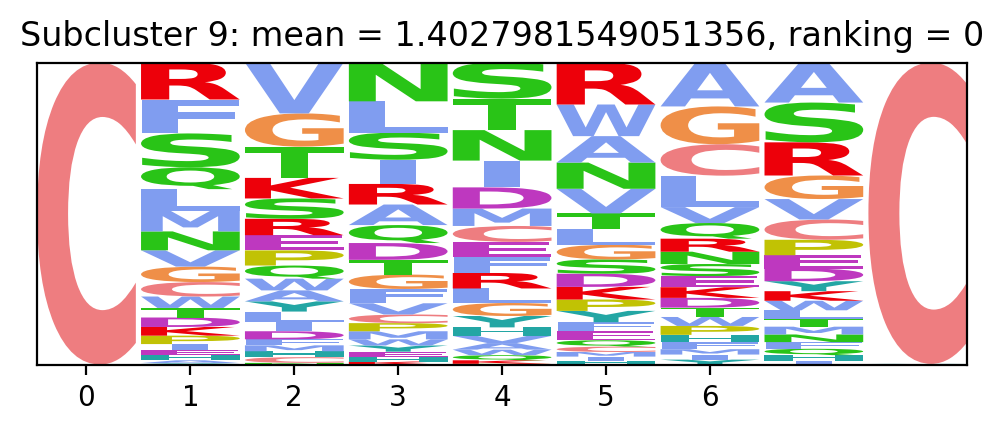

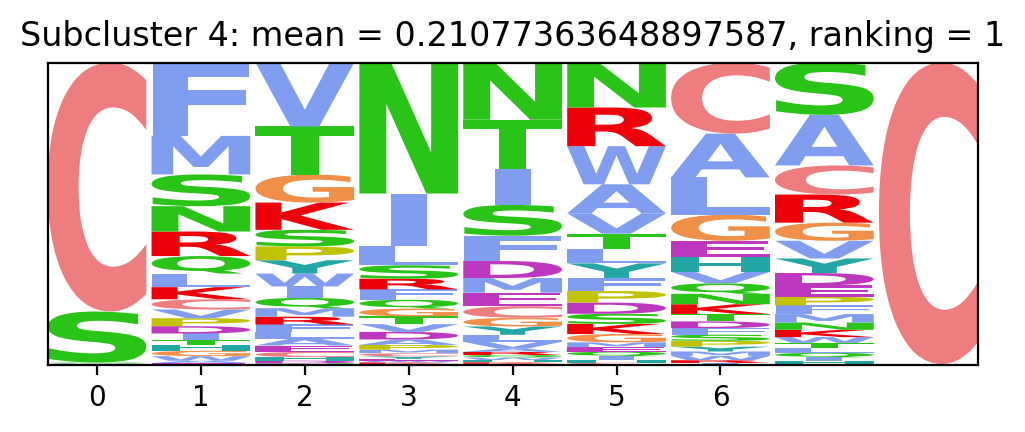

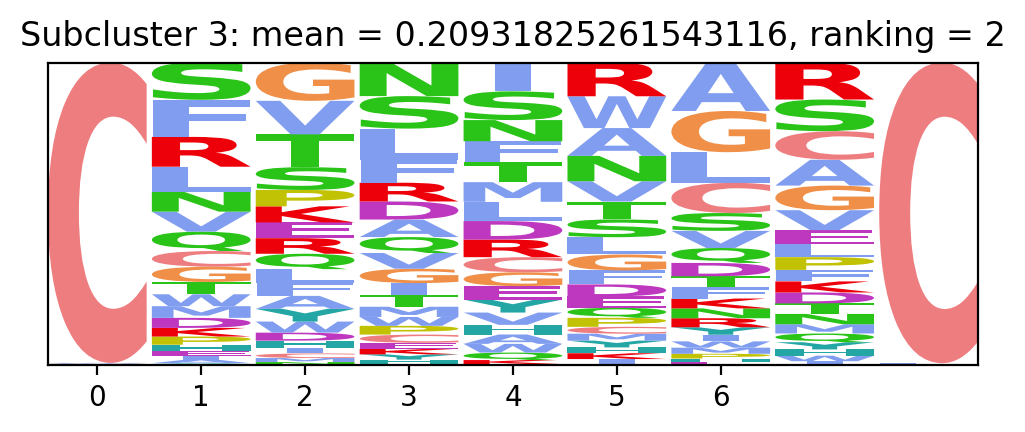

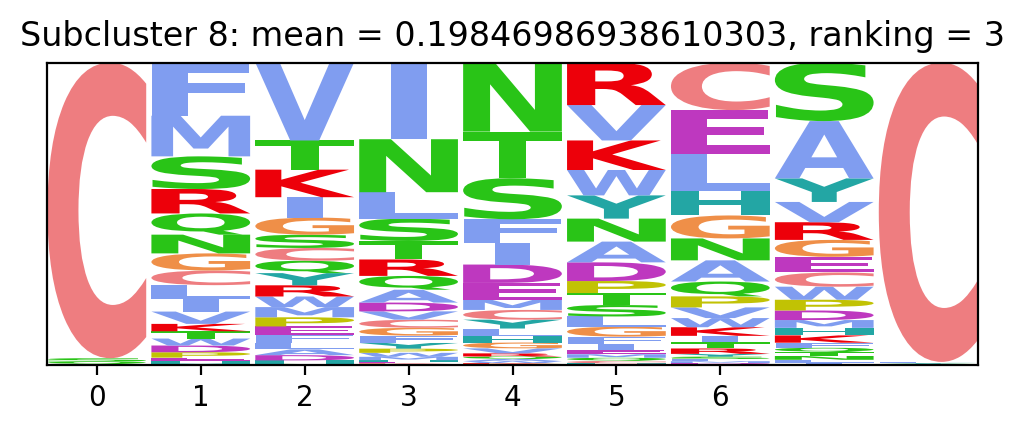

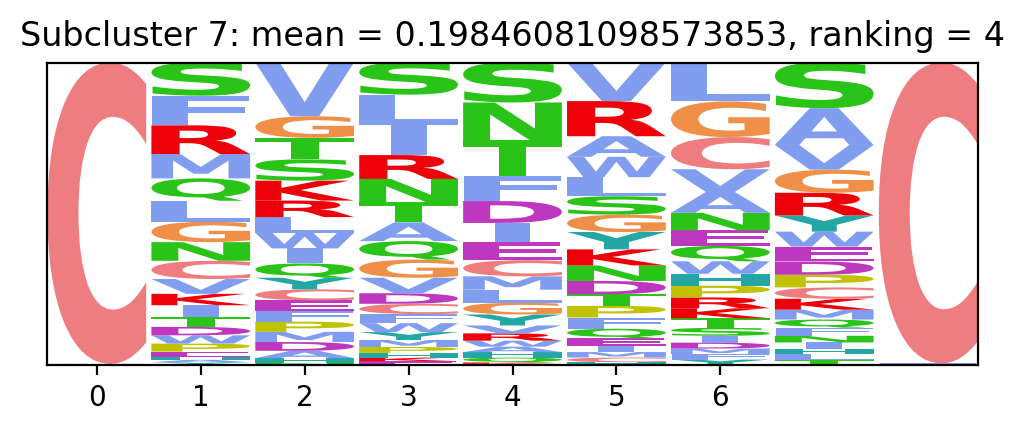

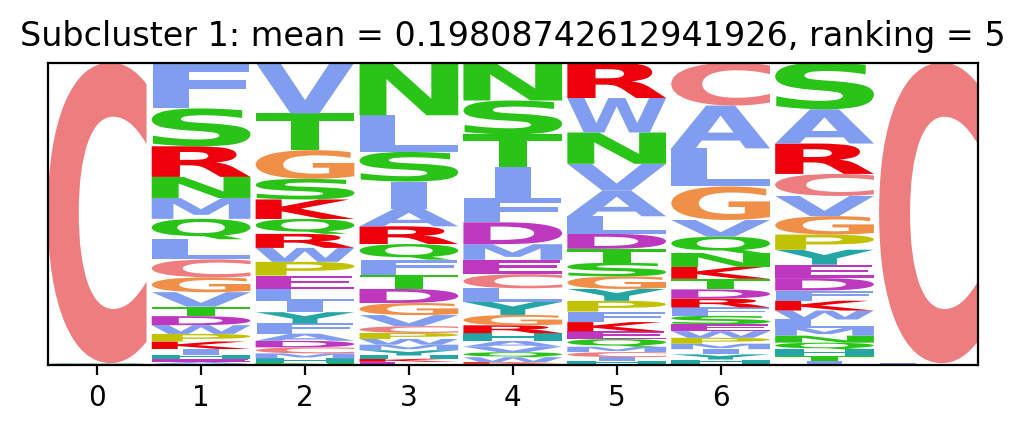

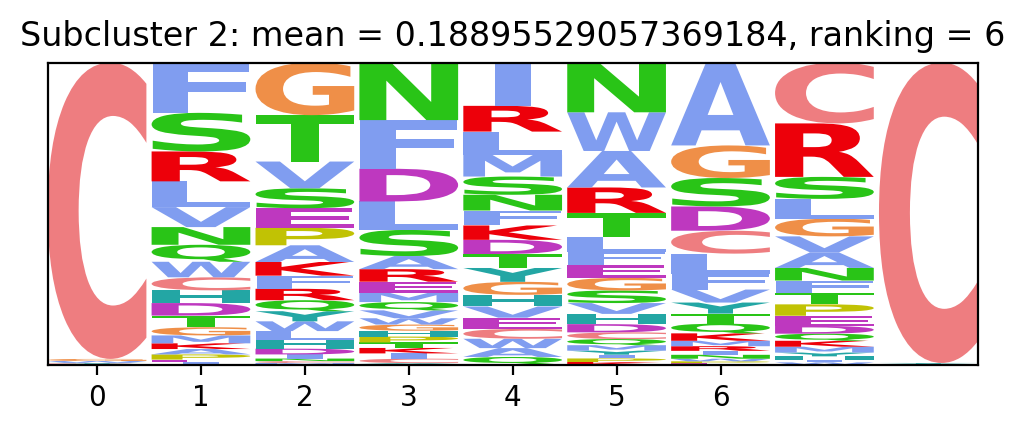

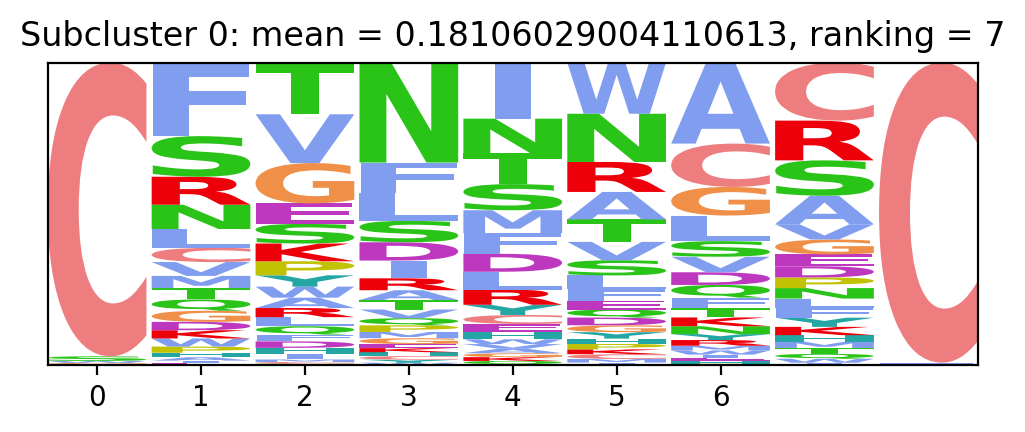

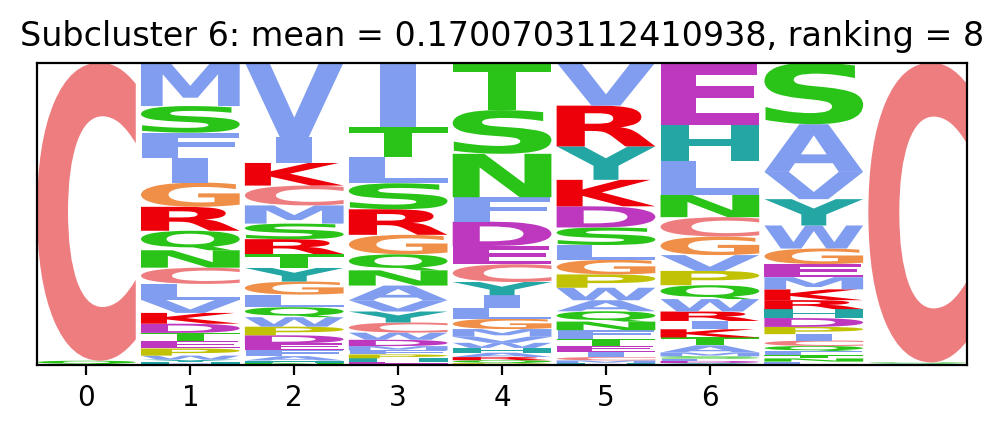

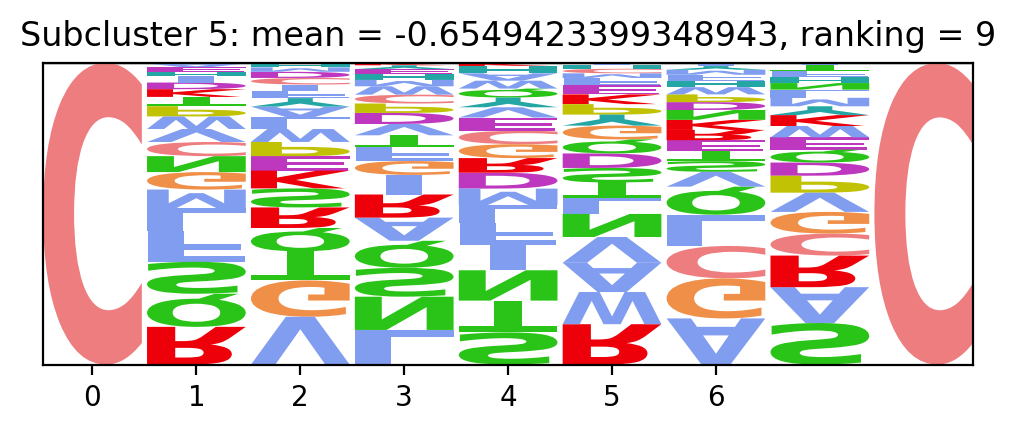

In [28]:
sequences_outdir = model_outdir / 'sequences'
cluster_model_outdir = model_outdir / 'kmeans_models'
generated_sequences_dict, generated_sequences_list = generate_sequences(preds_df, 
    assay=None,
    show_plots=True,
    show_logos=False,
    show_subcluster_plots=True,
    show_sublogos=False,
    plots_outdir=plots_outdir,
    cluster_model_outdir=cluster_model_outdir,
    subcluster_model_outdir=cluster_model_outdir,
    sequences_outdir=sequences_outdir,
    AA_percentile_threshold=80
    )